In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd


import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense


from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

In [6]:
# run
# Load dataset paths
train_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train"
test_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test"
train_csv_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv"
test_csv_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv"

In [7]:
# run
# Load CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [5]:
# Presenting the Raw Dataset and Dataset Description
print("First few rows of the dataset:")
display(train_df.head())
print("\nDataset Description:")
print(f"Number of records: {train_df.shape[0]}")
print(f"Number of features: {train_df.shape[1]}")
print("\nData Types:")
print(train_df.dtypes)
print("\nMissing Values Count:")
print(train_df.isnull().sum())

First few rows of the dataset:


filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop


Dataset Description:
Number of records: 12600
Number of features: 2

Data Types:
filename    object
label       object
dtype: object

Missing Values Count:
filename    0
label       0
dtype: int64


In [6]:
train_df.label.value_counts()

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

In [7]:
print(f"Duplicate rows: {train_df.duplicated().sum()}")
train_df = train_df.drop_duplicates()

Duplicate rows: 0


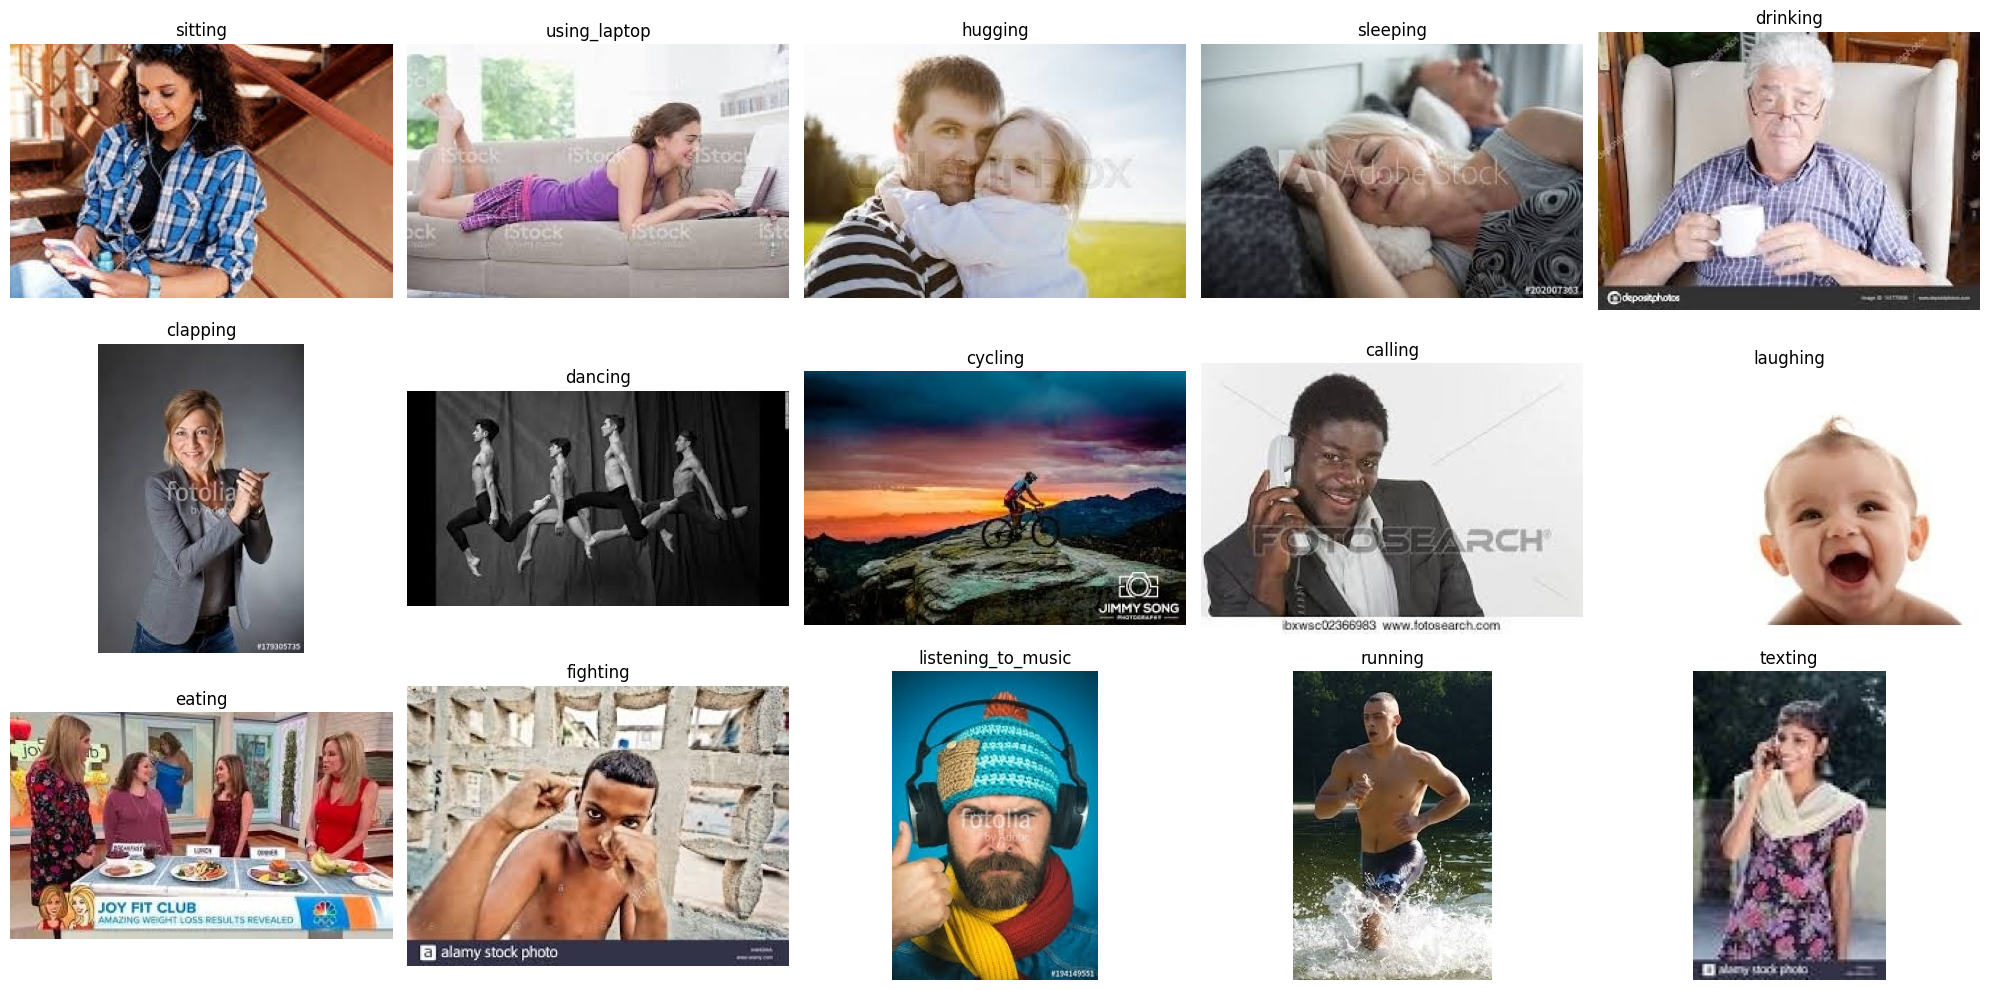

In [8]:
# Images from each class
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()
for idx, class_name in enumerate(train_df['label'].unique()):
    class_images = train_df[train_df['label'] == class_name]['filename'].values
    img = plt.imread(os.path.join(train_path, class_images[0]))
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

In [10]:
import plotly.express as px
# Distribution of classes in training set
fig = px.histogram(train_df, x='label', title='Distribution of Classes in Training Set')
fig.show()

In [8]:
# run
from sklearn.preprocessing import LabelEncoder

# Assuming df contains the 'label' column as categorical labels
label_encoder = LabelEncoder()

# Fit and transform labels into numeric form
train_df['label'] = label_encoder.fit_transform(train_df['label'])

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

# Step 2: Custom data generator


def custom_data_generator(df, image_dir, batch_size=32, target_size=(224, 224)):
    # Initialize the ImageDataGenerator for preprocessing
    datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Random rotation
    width_shift_range=0.2,      # Horizontal shift
    height_shift_range=0.2,     # Vertical shift
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Zoom
    horizontal_flip=True,       # Horizontal flip
    fill_mode='nearest'         # Fill empty pixels
)
    
    while True:
        # Shuffle the dataset each time
        df = df.sample(frac=1).reset_index(drop=True)
        
        # Iterate over the dataset in batches
        for start in range(0, len(df), batch_size):
            batch_df = df.iloc[start:start + batch_size]
            
            # Initialize lists to hold images and labels
            images = []
            labels = []
            
            for _, row in batch_df.iterrows():
                # Get the image path
                img_path = os.path.join(image_dir, row['filename'])
                
                # Load and preprocess the image
                img = load_img(img_path, target_size=target_size)  # Resize the image
                img_array = img_to_array(img)  # Convert to array
                
                # Preprocess the image for EfficientNet
                img_array = preprocess_input(img_array)
                
                images.append(img_array)
                labels.append(row['label'])
            
            # Convert lists to arrays
            images = np.array(images)
            labels = np.array(labels)
            
            # Yield the batch
            yield images, labels



def test_data_generator(df, image_dir, batch_size=32, target_size=(224, 224)):
    # Initialize the ImageDataGenerator for preprocessing
    datagen = ImageDataGenerator(rescale=1./255)
    
    while True:
        # Shuffle the dataset each time
        df = df.sample(frac=1).reset_index(drop=True)
        
        # Iterate over the dataset in batches
        for start in range(0, len(df), batch_size):
            batch_df = df.iloc[start:start + batch_size]
            
            # Initialize lists to hold images and labels
            images = []
            labels = []
            
            for _, row in batch_df.iterrows():
                # Get the image path
                img_path = os.path.join(image_dir, row['filename'])
                
                # Load and preprocess the image
                img = load_img(img_path, target_size=target_size)  # Resize the image
                img_array = img_to_array(img)  # Convert to array
                
                # Preprocess the image for EfficientNet
                img_array = preprocess_input(img_array)
                
                images.append(img_array)
                labels.append(row['label'])
            
            # Convert lists to arrays after collecting the full batch
            images = np.array(images)
            labels = np.array(labels)
            
            # Yield the batch
            yield images, labels


In [10]:
# run
# Step 2: Create the generator
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=train_df['label']  # Stratify by class labels
)
train_gen = custom_data_generator(train_df, train_path, batch_size=32)
valid_gen = test_data_generator(valid_df, train_path, batch_size=32)

In [11]:
# Class distribution in the training dataset
train_class_distribution = train_df['label'].value_counts()

# Class distribution in the validation dataset
valid_class_distribution = valid_df['label'].value_counts()

print("Training Class Distribution:")
print(train_class_distribution)

print("\nValidation Class Distribution:")
print(valid_class_distribution)

Training Class Distribution:
label
2     672
3     672
7     672
10    672
1     672
5     672
8     672
13    672
11    672
4     672
9     672
0     672
14    672
6     672
12    672
Name: count, dtype: int64

Validation Class Distribution:
label
1     168
12    168
14    168
6     168
0     168
7     168
11    168
2     168
4     168
5     168
10    168
9     168
3     168
13    168
8     168
Name: count, dtype: int64


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import EfficientNetB7

# Initialize the EfficientNetB7 model
efficientnet_model = Sequential()

# Load EfficientNetB7 with ImageNet weights and no top layer (for transfer learning)
model = EfficientNetB7(
    include_top=False,
    input_shape=(224, 224, 3),  # Adjusted input size
    pooling="avg",  # Global average pooling
    weights='imagenet'
)

# Freeze the layers of EfficientNetB7 to avoid retraining the base model
for layer in model.layers:
    layer.trainable = False

# Add EfficientNetB7 base model
efficientnet_model.add(model)
efficientnet_model.add(Flatten())  # Flatten the output for dense layers
efficientnet_model.add(Dense(512, activation="relu"))  # Fully connected layer
efficientnet_model.add(Dense(15, activation="softmax"))  # Output layer for 15 classes

# Compile the model
efficientnet_model.compile(optimizer='adam', 
                           loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if using one-hot labels
                           metrics=['accuracy'])


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
# Train the model
efficientnet_model.fit(train_gen,steps_per_epoch=len(train_df) // 32, epochs=20)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 133s 220ms/step - accuracy: 0.5108 - loss: 1.5369
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step - accuracy: 0.6906 - loss: 0.9434
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.7762 - loss: 0.6987
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.8475 - loss: 0.4782
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.8872 - loss: 0.3596
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9272 - loss: 0.2495
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9464 - loss: 0.1796
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9562 - loss: 0.1496
Epoch 9/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9692 - loss: 0.1117
Epoch 10/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9653 - loss: 0.1110
Epoch 11/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9733 - loss: 0.0915
Epoch 12/20
315/31

In [16]:
# Evaluate the model on the validation generator
val_loss, val_accuracy = efficientnet_model.evaluate(valid_gen, steps=len(valid_df) // 32)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 30s 210ms/step - accuracy: 0.6350 - loss: 2.1218
Validation Loss: 2.159212112426758
Validation Accuracy: 0.6274038553237915


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


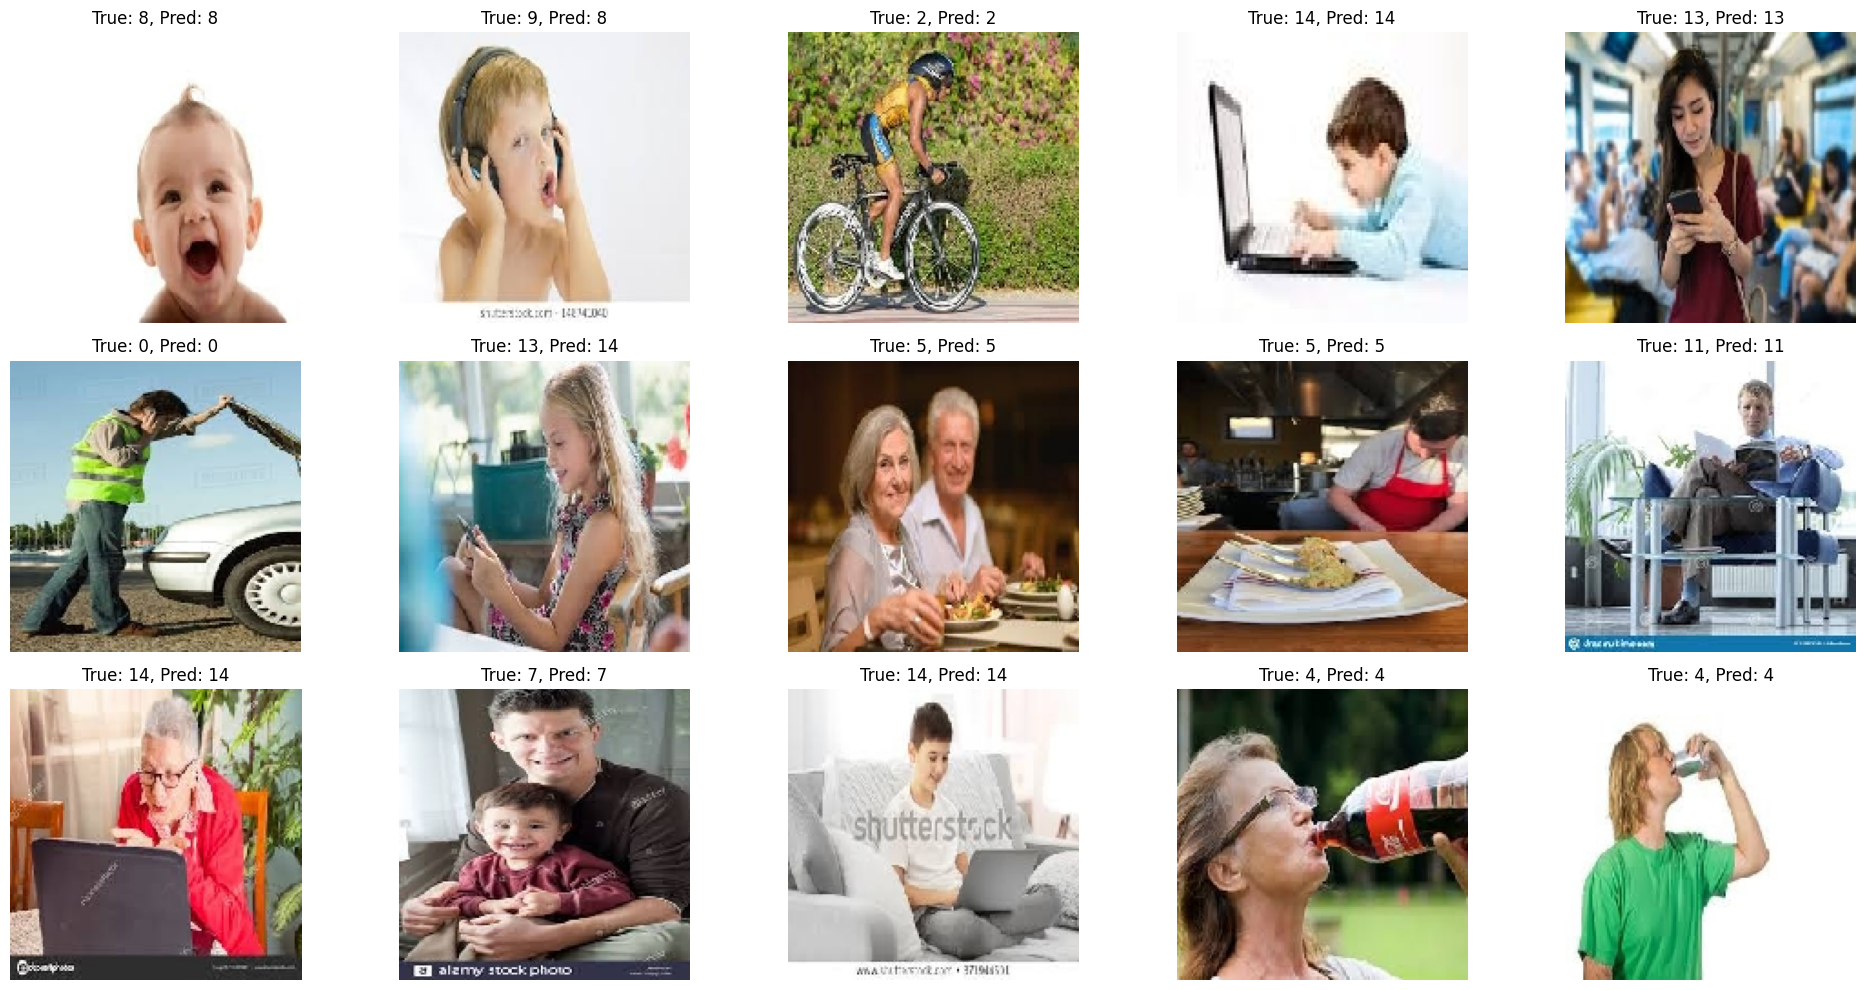

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from valid_gen
images, labels = next(valid_gen)

# Rescale images if they are normalized (assuming normalization to 0-1 range)
images = (images * 255).astype('uint8') if images.max() <= 1 else images.astype('uint8')

# Predict on this batch
preds = efficientnet_model.predict(images)
predicted_classes = preds.argmax(axis=-1)

# Create a grid of plots to show true and predicted labels
fig, axes = plt.subplots(3, 5, figsize=(20, 10))  # Adjust rows and cols as needed
axes = axes.flatten()

# Plot each image with its true and predicted labels
for idx in range(min(len(images), 15)):  # Limit to 15 images for display
    axes[idx].imshow(images[idx])
    axes[idx].set_title(f"True: {labels[idx]}, Pred: {predicted_classes[idx]}")
    axes[idx].axis('off')

# Hide any unused axes
for ax in axes[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()



added regularization and dropout layer to avoid overfitting also used early stoping

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau 

# Initialize the EfficientNetB7 model
model2 = Sequential()

# Base EfficientNet model
model = tf.keras.applications.EfficientNetB7(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling="avg",
    weights='imagenet'
)
for layer in model.layers[-30:]:  # Unfreeze the top 30 layers
    layer.trainable = True

# Build the model
model2.add(model)

# Add a Flatten layer
model2.add(Flatten())

model2.add(Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(0.5))

model2.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Dropout(0.5))


# Add another Dense layer for the output with Softmax activation
model2.add(Dense(15, activation="softmax"))


optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# Compile the model
model2.compile(optimizer=optimizer, 
                           loss='sparse_categorical_crossentropy', 
                           metrics=['accuracy'])


# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  # Number of epochs with no improvement after which training will stop
                               restore_best_weights=True)  # Restore the best weights after training stops


In [13]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
# Fit the model with the EarlyStopping callback
history = model2.fit(
    train_gen,
    steps_per_epoch=len(train_df) // 32,
    epochs=30,
    validation_data=valid_gen,
    validation_steps=len(valid_df) // 32,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/30
271/315 ━━━━━━━━━━━━━━━━━━━━ 29s 660ms/step - accuracy: 0.3030 - loss: 12.3043

In [42]:
# Evaluate the model on the validation generator
val_loss, val_accuracy = model2.evaluate(valid_gen, steps=len(valid_df) // 32)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.6237 - loss: 1.6313
Validation Loss: 1.6536035537719727
Validation Accuracy: 0.6097266674041748


In [ ]:
losses = history.history["loss"]
plt.plot(losses)

In [ ]:
acc = history.history["accuracy"]
plt.plot(acc)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get a batch from valid_gen
images, y_true = next(valid_gen)

# Predict on this batch
preds = model3.predict(images)
predicted_classes = preds.argmax(axis=-1)

# Convert y_true from one-hot encoding to class labels, if needed
if y_true.ndim > 1:  # Assuming y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=-1)

# Print classification report
print(classification_report(y_true, predicted_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


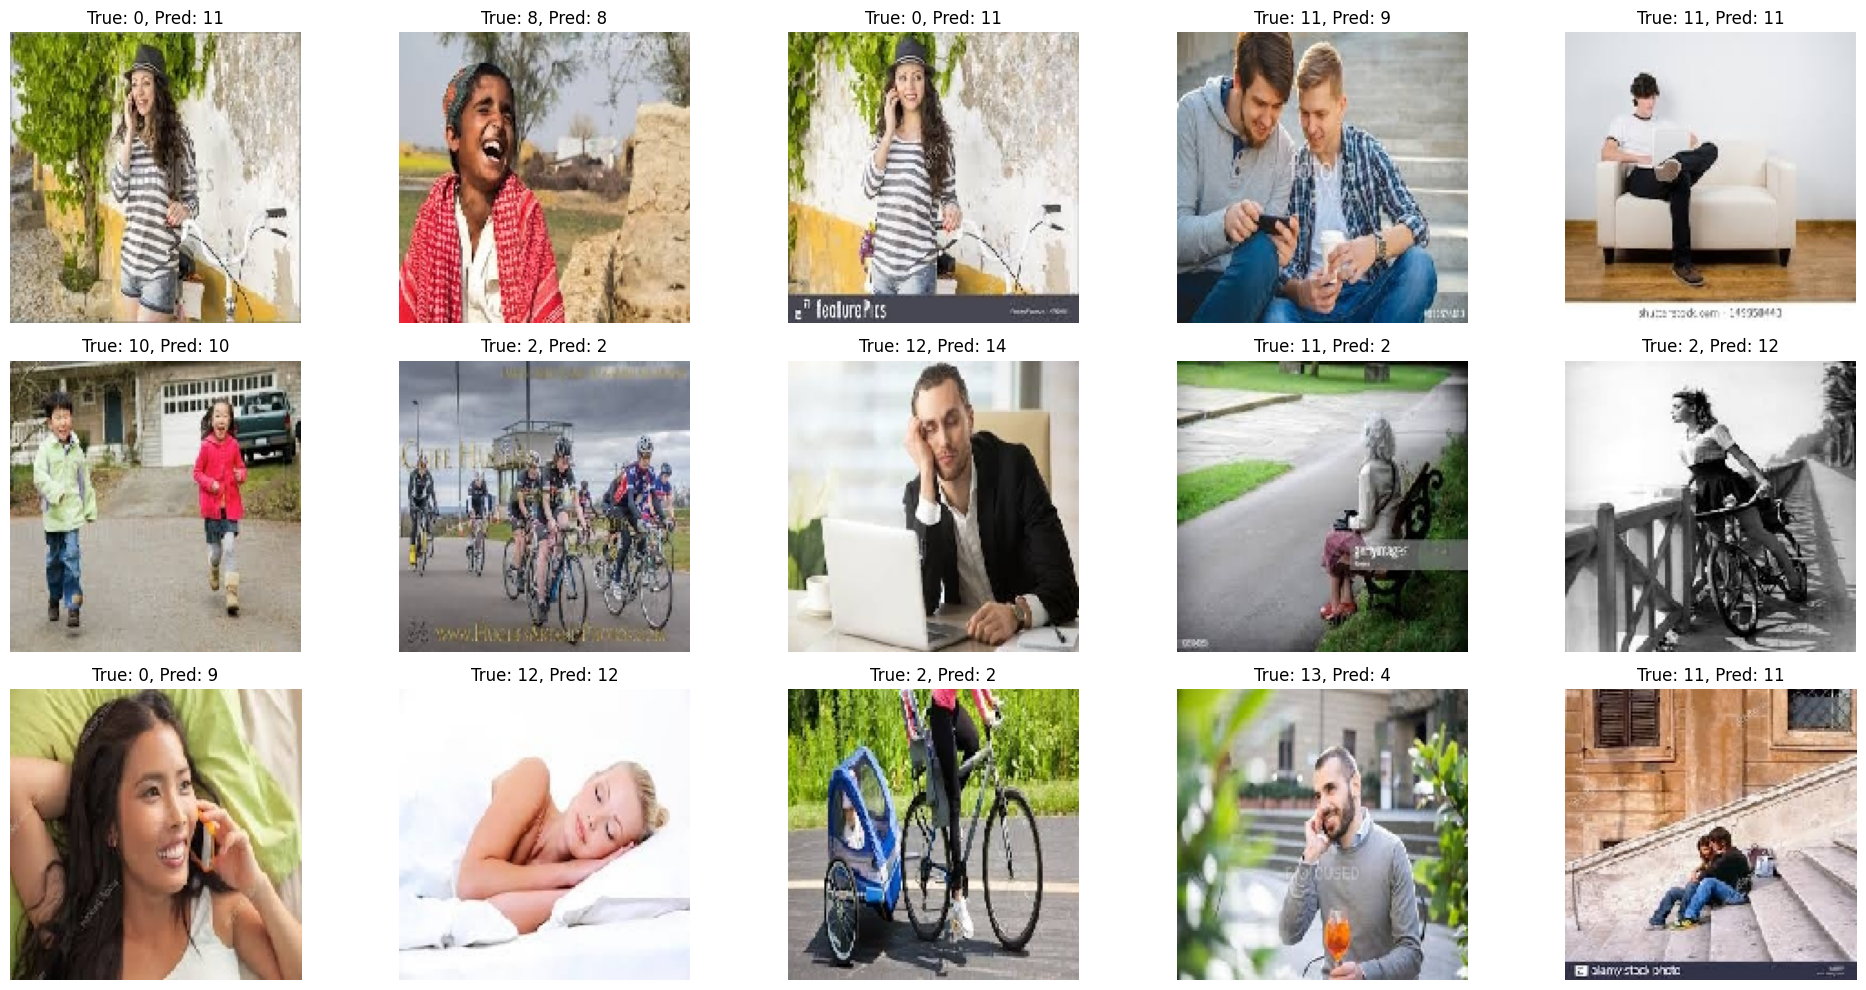

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch from valid_gen
images, labels = next(valid_gen)

# Rescale images if they are normalized (assuming normalization to 0-1 range)
images = (images * 255).astype('uint8') if images.max() <= 1 else images.astype('uint8')

# Predict on this batch
preds = model2.predict(images)
predicted_classes = preds.argmax(axis=-1)

# Create a grid of plots to show true and predicted labels
fig, axes = plt.subplots(3, 5, figsize=(20, 10))  # Adjust rows and cols as needed
axes = axes.flatten()

# Plot each image with its true and predicted labels
for idx in range(min(len(images), 15)):  # Limit to 15 images for display
    axes[idx].imshow(images[idx])
    axes[idx].set_title(f"True: {labels[idx]}, Pred: {predicted_classes[idx]}")
    axes[idx].axis('off')

# Hide any unused axes
for ax in axes[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau 

# Initialize the EfficientNetB7 model
model3 = Sequential()

# Base EfficientNet model
model = tf.keras.applications.EfficientNetB7(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling="avg",
    weights='imagenet'
)
for layer in model.layers[-30:]:  # Unfreeze the top 30 layers
    layer.trainable = True

# Build the model
model3.add(model)

# Add a Flatten layer
model3.add(Flatten())

model3.add(Dense(512, kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Dropout(0.5))

model3.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Dropout(0.5))


# Add another Dense layer for the output with Softmax activation
model3.add(Dense(15, activation="softmax"))

# Compile the model
model3.compile(optimizer='adam', 
                           loss='sparse_categorical_crossentropy', 
                           metrics=['accuracy'])

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5,  # Number of epochs with no improvement after which training will stop
                               restore_best_weights=True)  # Restore the best weights after training stops


In [25]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [26]:
# Fit the model with the EarlyStopping callback
model3.fit(
    train_gen,
    steps_per_epoch=len(train_df) // 32,
    epochs=30,
    validation_data=valid_gen,
    validation_steps=len(valid_df) // 32,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 455s 799ms/step - accuracy: 0.3363 - loss: 10.4583 - val_accuracy: 0.4864 - val_loss: 3.5777 - learning_rate: 0.0010
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 237s 752ms/step - accuracy: 0.5824 - loss: 2.7224 - val_accuracy: 0.5993 - val_loss: 2.0713 - learning_rate: 0.0010
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 228s 723ms/step - accuracy: 0.6746 - loss: 1.8412 - val_accuracy: 0.5410 - val_loss: 2.1131 - learning_rate: 0.0010
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 229s 726ms/step - accuracy: 0.7262 - loss: 1.5008 - val_accuracy: 0.6415 - val_loss: 1.7959 - learning_rate: 0.0010
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 229s 726ms/step - accuracy: 0.7761 - loss: 1.2954 - val_accuracy: 0.6841 - val_loss: 1.5771 - learning_rate: 0.0010
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 227s 720ms/step - accuracy: 0.7948 - loss: 1.2024 - val_accuracy: 0.6668 - val_loss: 1.7336 - learning_rate: 0.0010
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 227s 721ms/step - accur

In [27]:
# Evaluate the model on the validation generator
val_loss, val_accuracy = model3.evaluate(valid_gen, steps=len(valid_df) // 32)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - accuracy: 0.7568 - loss: 1.1287
Validation Loss: 1.1982371807098389
Validation Accuracy: 0.737942099571228


In [34]:
from sklearn.metrics import classification_report
import numpy as np

# Get a batch from valid_gen
images, y_true = next(valid_gen)

# Predict on this batch
preds = model3.predict(images)
predicted_classes = preds.argmax(axis=-1)

# Convert y_true from one-hot encoding to class labels, if needed
if y_true.ndim > 1:  # Assuming y_true is one-hot encoded
    y_true = np.argmax(y_true, axis=-1)

# Print classification report
print(classification_report(y_true, predicted_classes))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.50      0.67         4
           2       0.67      1.00      0.80         2
           3       1.00      0.67      0.80         3
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         3
           8       0.50      1.00      0.67         1
           9       1.00      0.60      0.75         5
          10       1.00      1.00      1.00         1
          11       0.67      0.67      0.67         3
          12       0.00      0.00      0.00         2
          13       0.50      1.00      0.67         2
          14       0.00      0.00      0.00         1

    accuracy                           0.69        32
   macro avg       0.62      0.63      0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


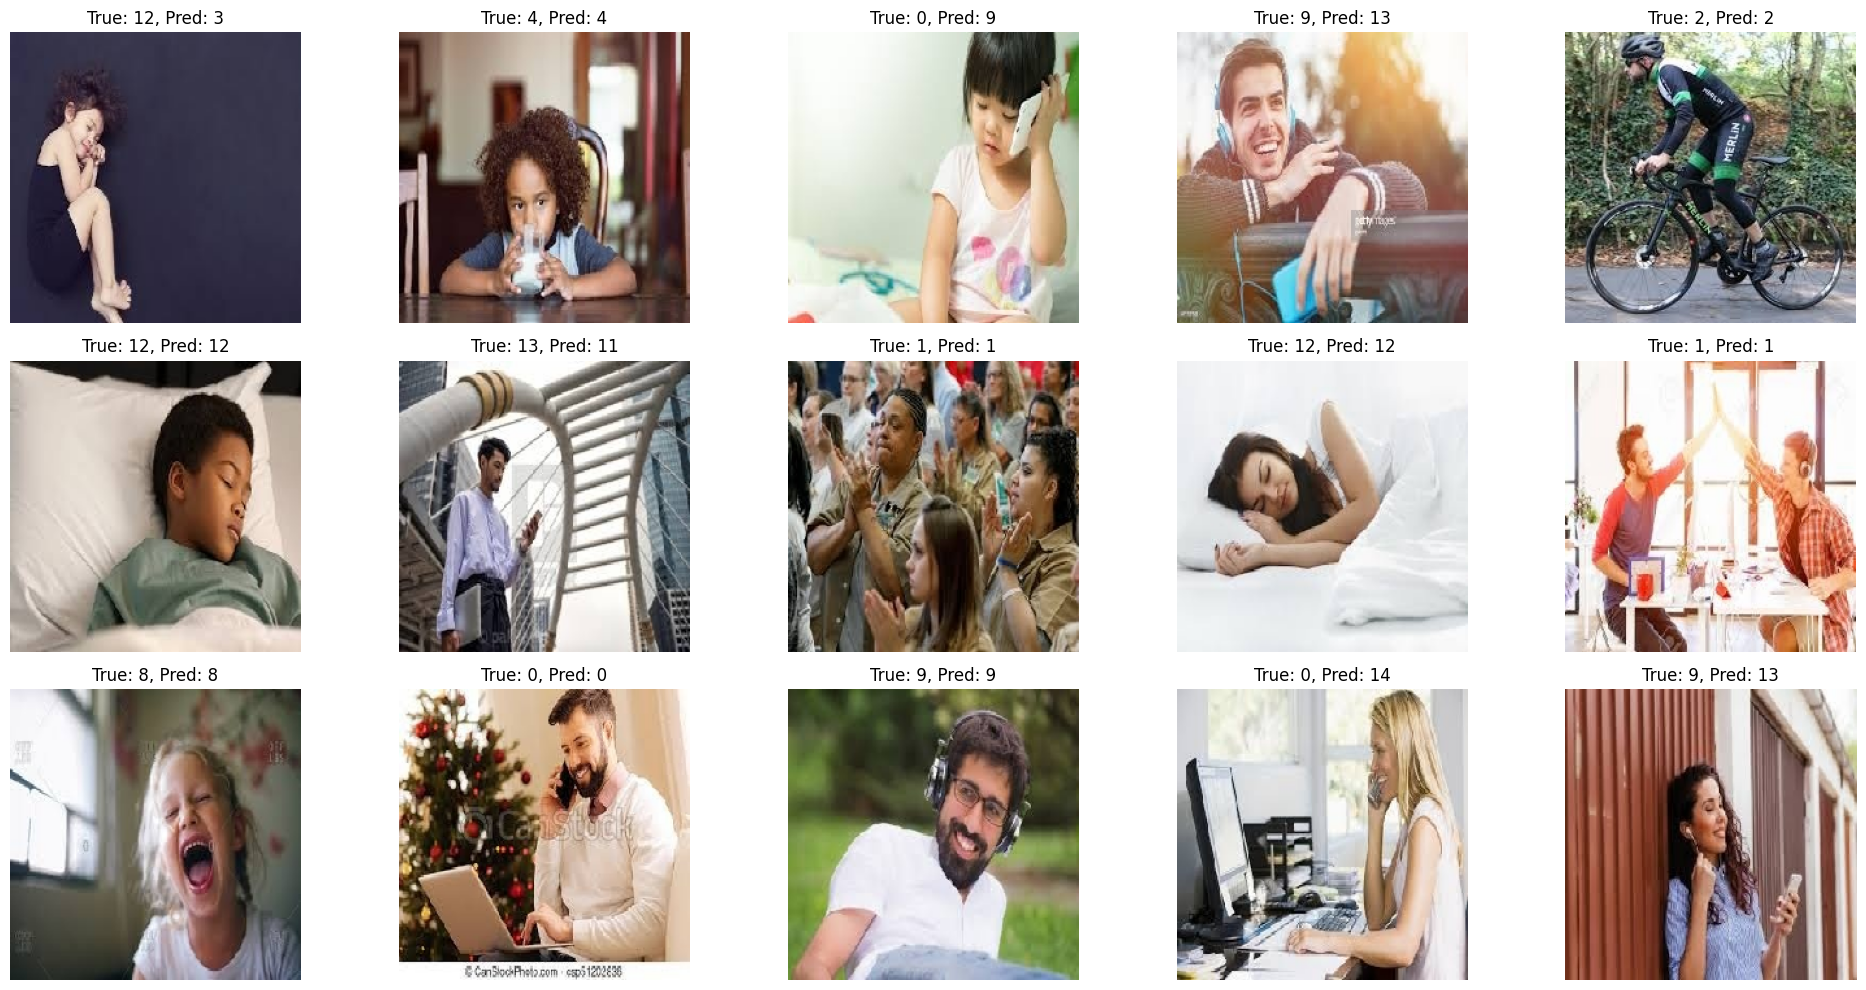

In [31]:
# Get a batch from valid_gen
images, labels = next(valid_gen)

# Rescale images if they are normalized (assuming normalization to 0-1 range)
images = (images * 255).astype('uint8') if images.max() <= 1 else images.astype('uint8')

# Predict on this batch
preds = model3.predict(images)
predicted_classes = preds.argmax(axis=-1)

# Create a grid of plots to show true and predicted labels
fig, axes = plt.subplots(3, 5, figsize=(20, 10))  # Adjust rows and cols as needed
axes = axes.flatten()

# Plot each image with its true and predicted labels
for idx in range(min(len(images), 15)):  # Limit to 15 images for display
    axes[idx].imshow(images[idx])
    axes[idx].set_title(f"True: {labels[idx]}, Pred: {predicted_classes[idx]}")
    axes[idx].axis('off')

# Hide any unused axes
for ax in axes[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
losses = history.history["loss"]
plt.plot(losses)

In [ ]:
acc = history.history['accuracy']
plt.plot(acc)